In [26]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

In [27]:
class FairFaceDataset(Dataset):
    """FairFace dataset."""

    def __init__(self, root_dir, train=True, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        if train:
            csv_file = os.path.join(root_dir, 'fairface_label_train.csv')
            self.anno = pd.read_csv(csv_file)
        else:
            csv_file = os.path.join(root_dir, 'fairface_label_val.csv')
            self.anno = pd.read_csv(csv_file)

        self.enc_age = {"0-2": 0, "3-9": 1, "10-19": 2, "20-29": 3, "30-39": 4, "40-49": 5, "50-59": 6, "60-69": 7, "more than 70": 8}
        self.enc_gender = {"Male": 0, "Female": 1}
        self.enc_race = {"White": 0, "Latino_Hispanic": 1, "Indian": 2, "East Asian": 3, "Black": 4, "Southeast Asian": 5, "Middle Eastern": 6}

        # Convert categorical labels to numerical labels
        self.anno["age"] = self.anno["age"].map(self.enc_age)
        self.anno["gender"] = self.anno["gender"].map(self.enc_gender)
        self.anno["race"] = self.anno["race"].map(self.enc_race)

    def apply_bias(self):
        """Randomly removes half of all women and half of each specified race (Black, Indian, Middle Eastern)."""
        
        # Remove half of women
        women_indices = self.anno[self.anno["gender"] == 1].index
        women_to_remove = np.random.choice(women_indices, size=len(women_indices) // 2, replace=False)

        # Remove half of each specified race individually
        races_to_remove = [2, 4, 6]  # Indian, Black, Middle Eastern
        race_removals = []
        
        for race in races_to_remove:
            race_indices = self.anno[self.anno["race"] == race].index
            race_to_remove = np.random.choice(race_indices, size=len(race_indices) // 2, replace=False)
            race_removals.extend(race_to_remove)

        # Combine indices to remove
        to_remove = np.concatenate([women_to_remove, race_removals])
        
        # Drop selected rows
        self.anno = self.anno.drop(to_remove).reset_index(drop=True)

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.anno.iloc[idx, 0])
        image = Image.open(img_name)
        labels = self.anno.iloc[idx, 1:4].to_list()
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [28]:
ds = FairFaceDataset("Z:\\data\\fairface-img-margin025-trainval", transform = None )

In [29]:
len(ds)

86744

In [30]:
ds2 = FairFaceDataset("Z:\\data\\fairface-img-margin025-trainval", transform = None )
ds2.apply_bias()

len(ds2)

53162

In [53]:
import matplotlib.pyplot as plt

def plot_histogram(anno, title, column, xlabel, bins=None, label_map=None, color_map=None):
    """Plot a histogram of a specific column in the annotations, with centered x-axis labels and custom colors."""
    plt.figure(figsize=(10, 6), dpi=300)  # Increase DPI for higher resolution
    
    if bins is None:
        bins = range(min(anno[column]), max(anno[column]) + 2)  # Ensure range fits binary/categorical data
    
    # Plot the histogram and capture the patches for later modification
    counts, bin_edges, patches = plt.hist(anno[column], bins=bins, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    
    # Set x-ticks to the manual labels and center them
    if label_map:
        labels = [label_map[i] for i in bins[:-1]]  # Map the bin values to labels
        
        # Calculate the center of each bin for label positioning
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Set the xticks to be the bin centers and assign the corresponding labels
        plt.xticks(bin_centers, labels, rotation=0, ha='center')  # 'ha' is the horizontal alignment
        
    # Apply custom colors if color_map is provided
    if color_map:
        for i, patch in enumerate(patches):
            # Color each bin according to the custom color map
            patch.set_facecolor(color_map[i % len(color_map)])  # Use modulo to cycle through colors if there are more bins than colors
    
    plt.show()


age_labels = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Latino/Hispanic", "Indian", "East Asian", "Black", "Southeast \n Asian", "Middle Eastern"]

age_colors = ['#FF9999', '#FFCC99', '#99FF99', '#99CCFF', '#FF99FF', '#FFFF99', '#CCFFCC', '#FFCCFF', '#99FFFF']
gender_colors = ['#FFB6C1', '#ADD8E6']
race_colors = ['#FF6347', '#FFD700', '#90EE90', '#87CEFA', '#FF4500', '#32CD32', '#800080']


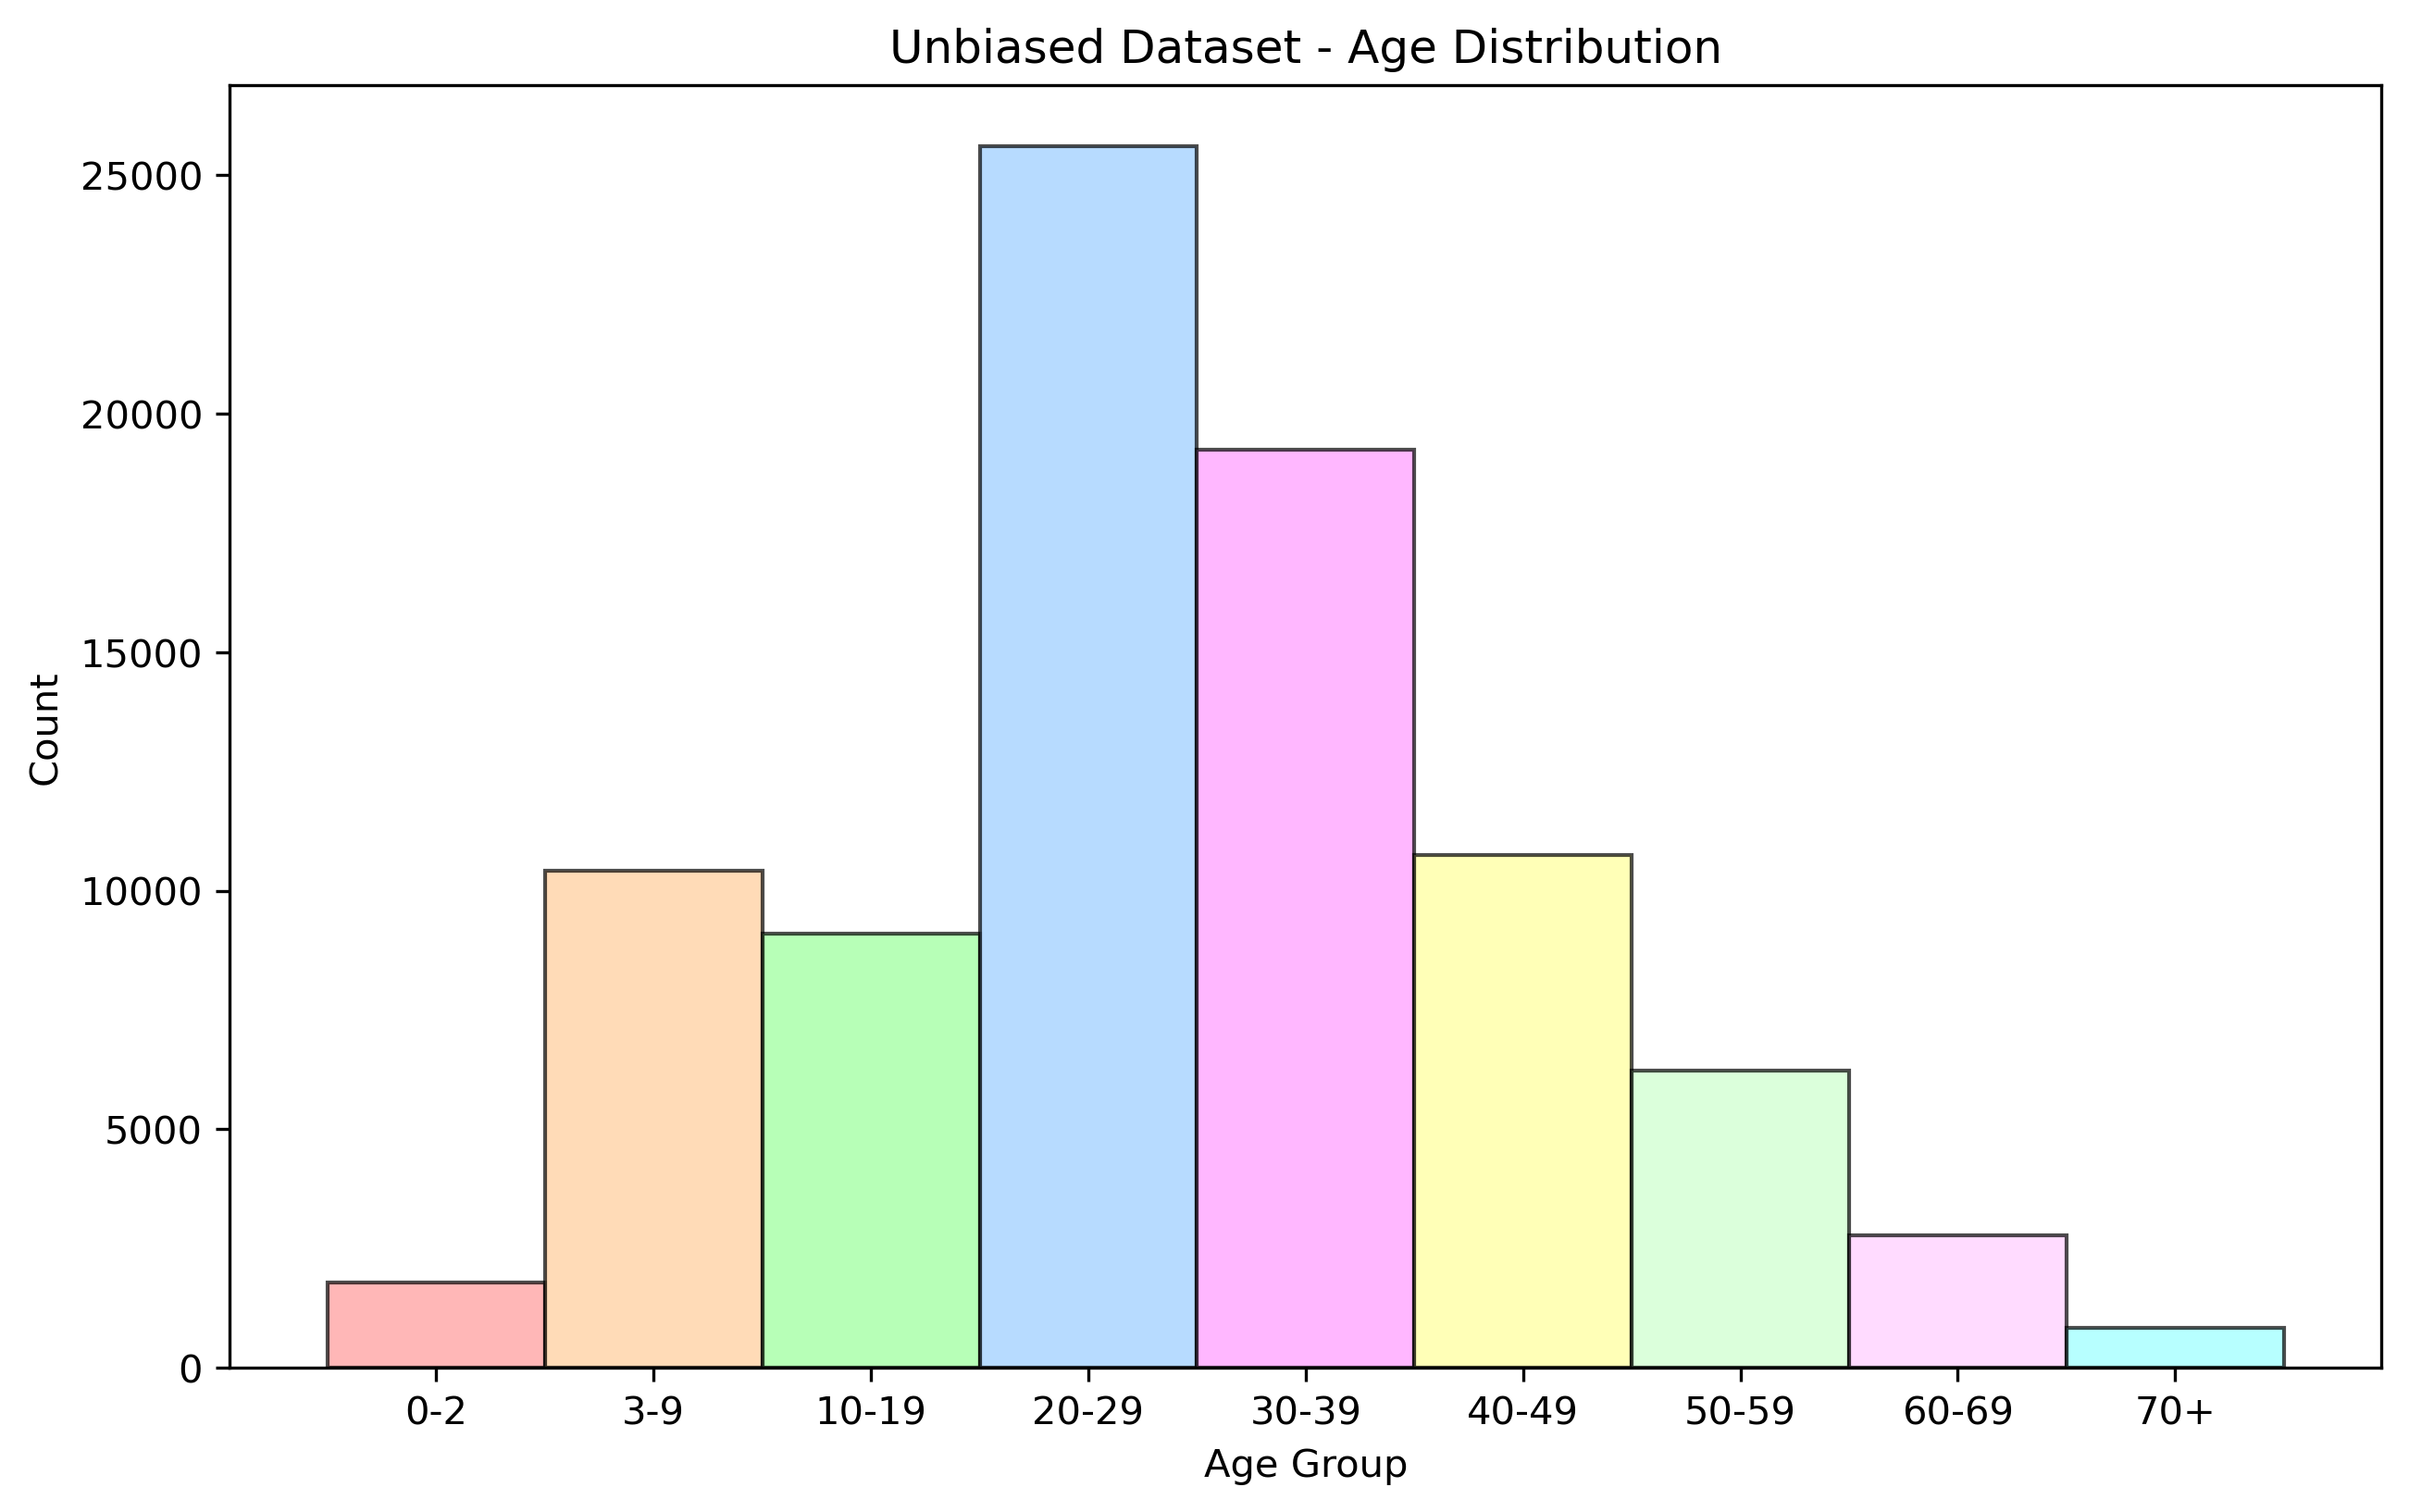

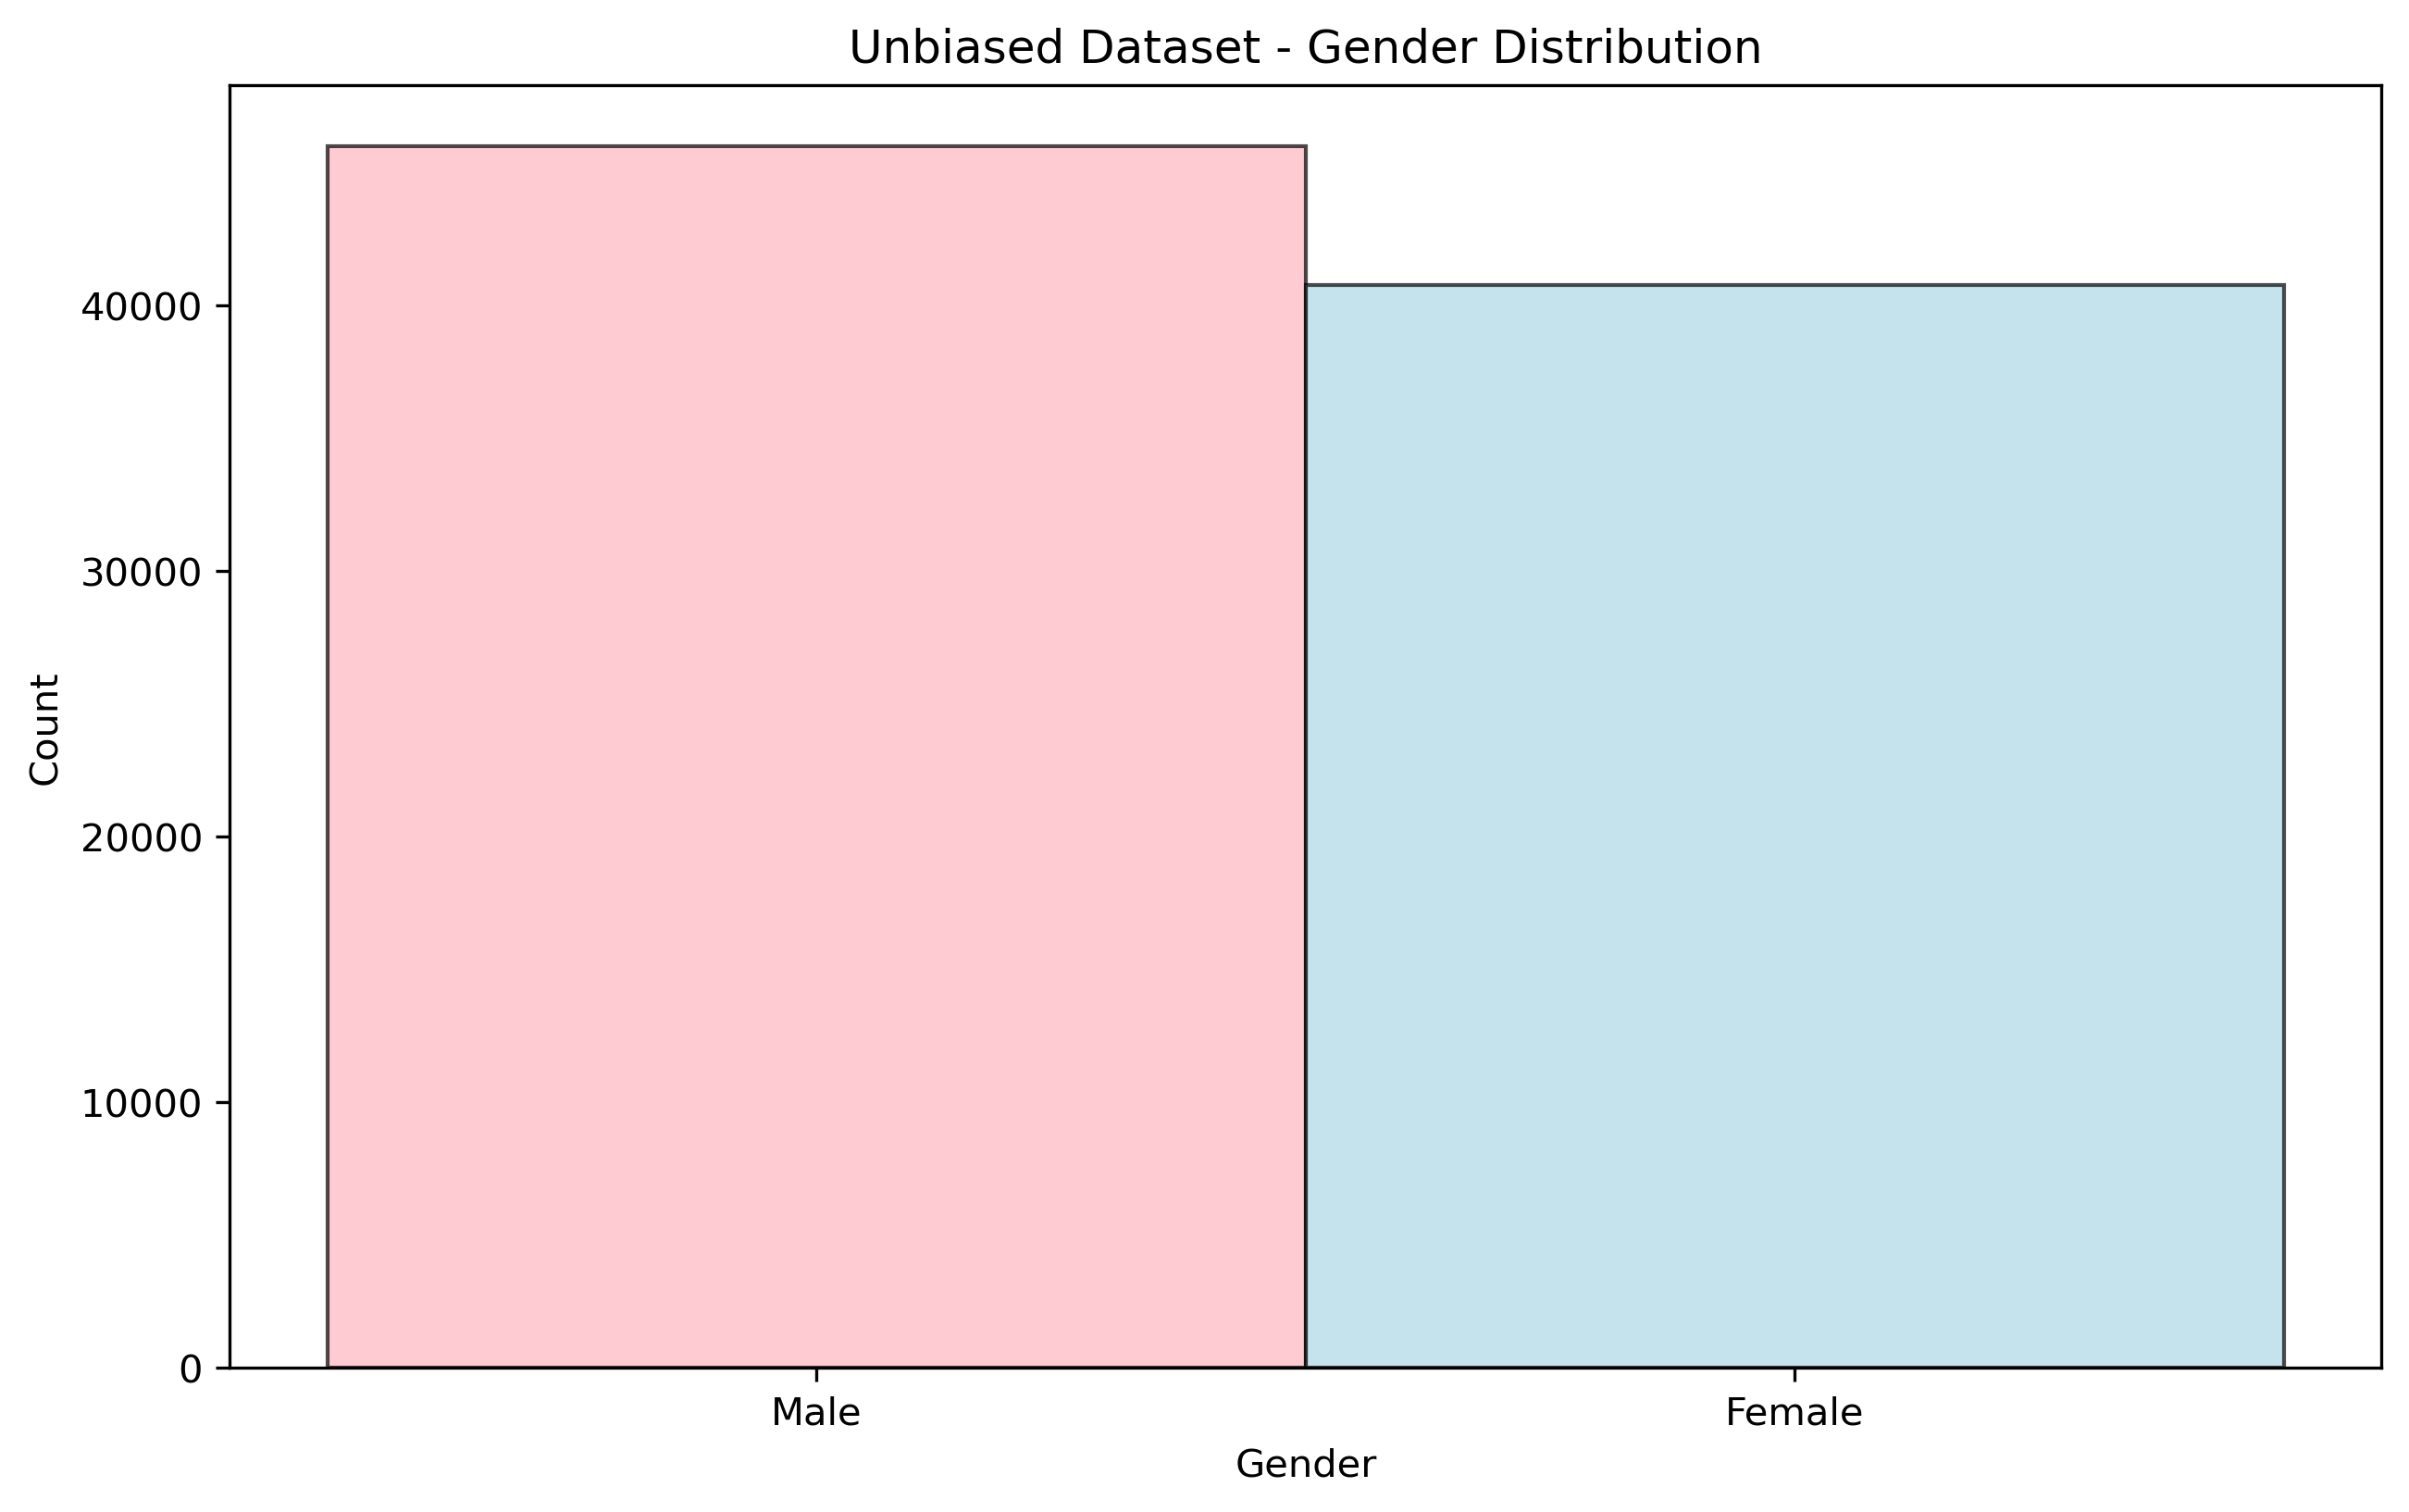

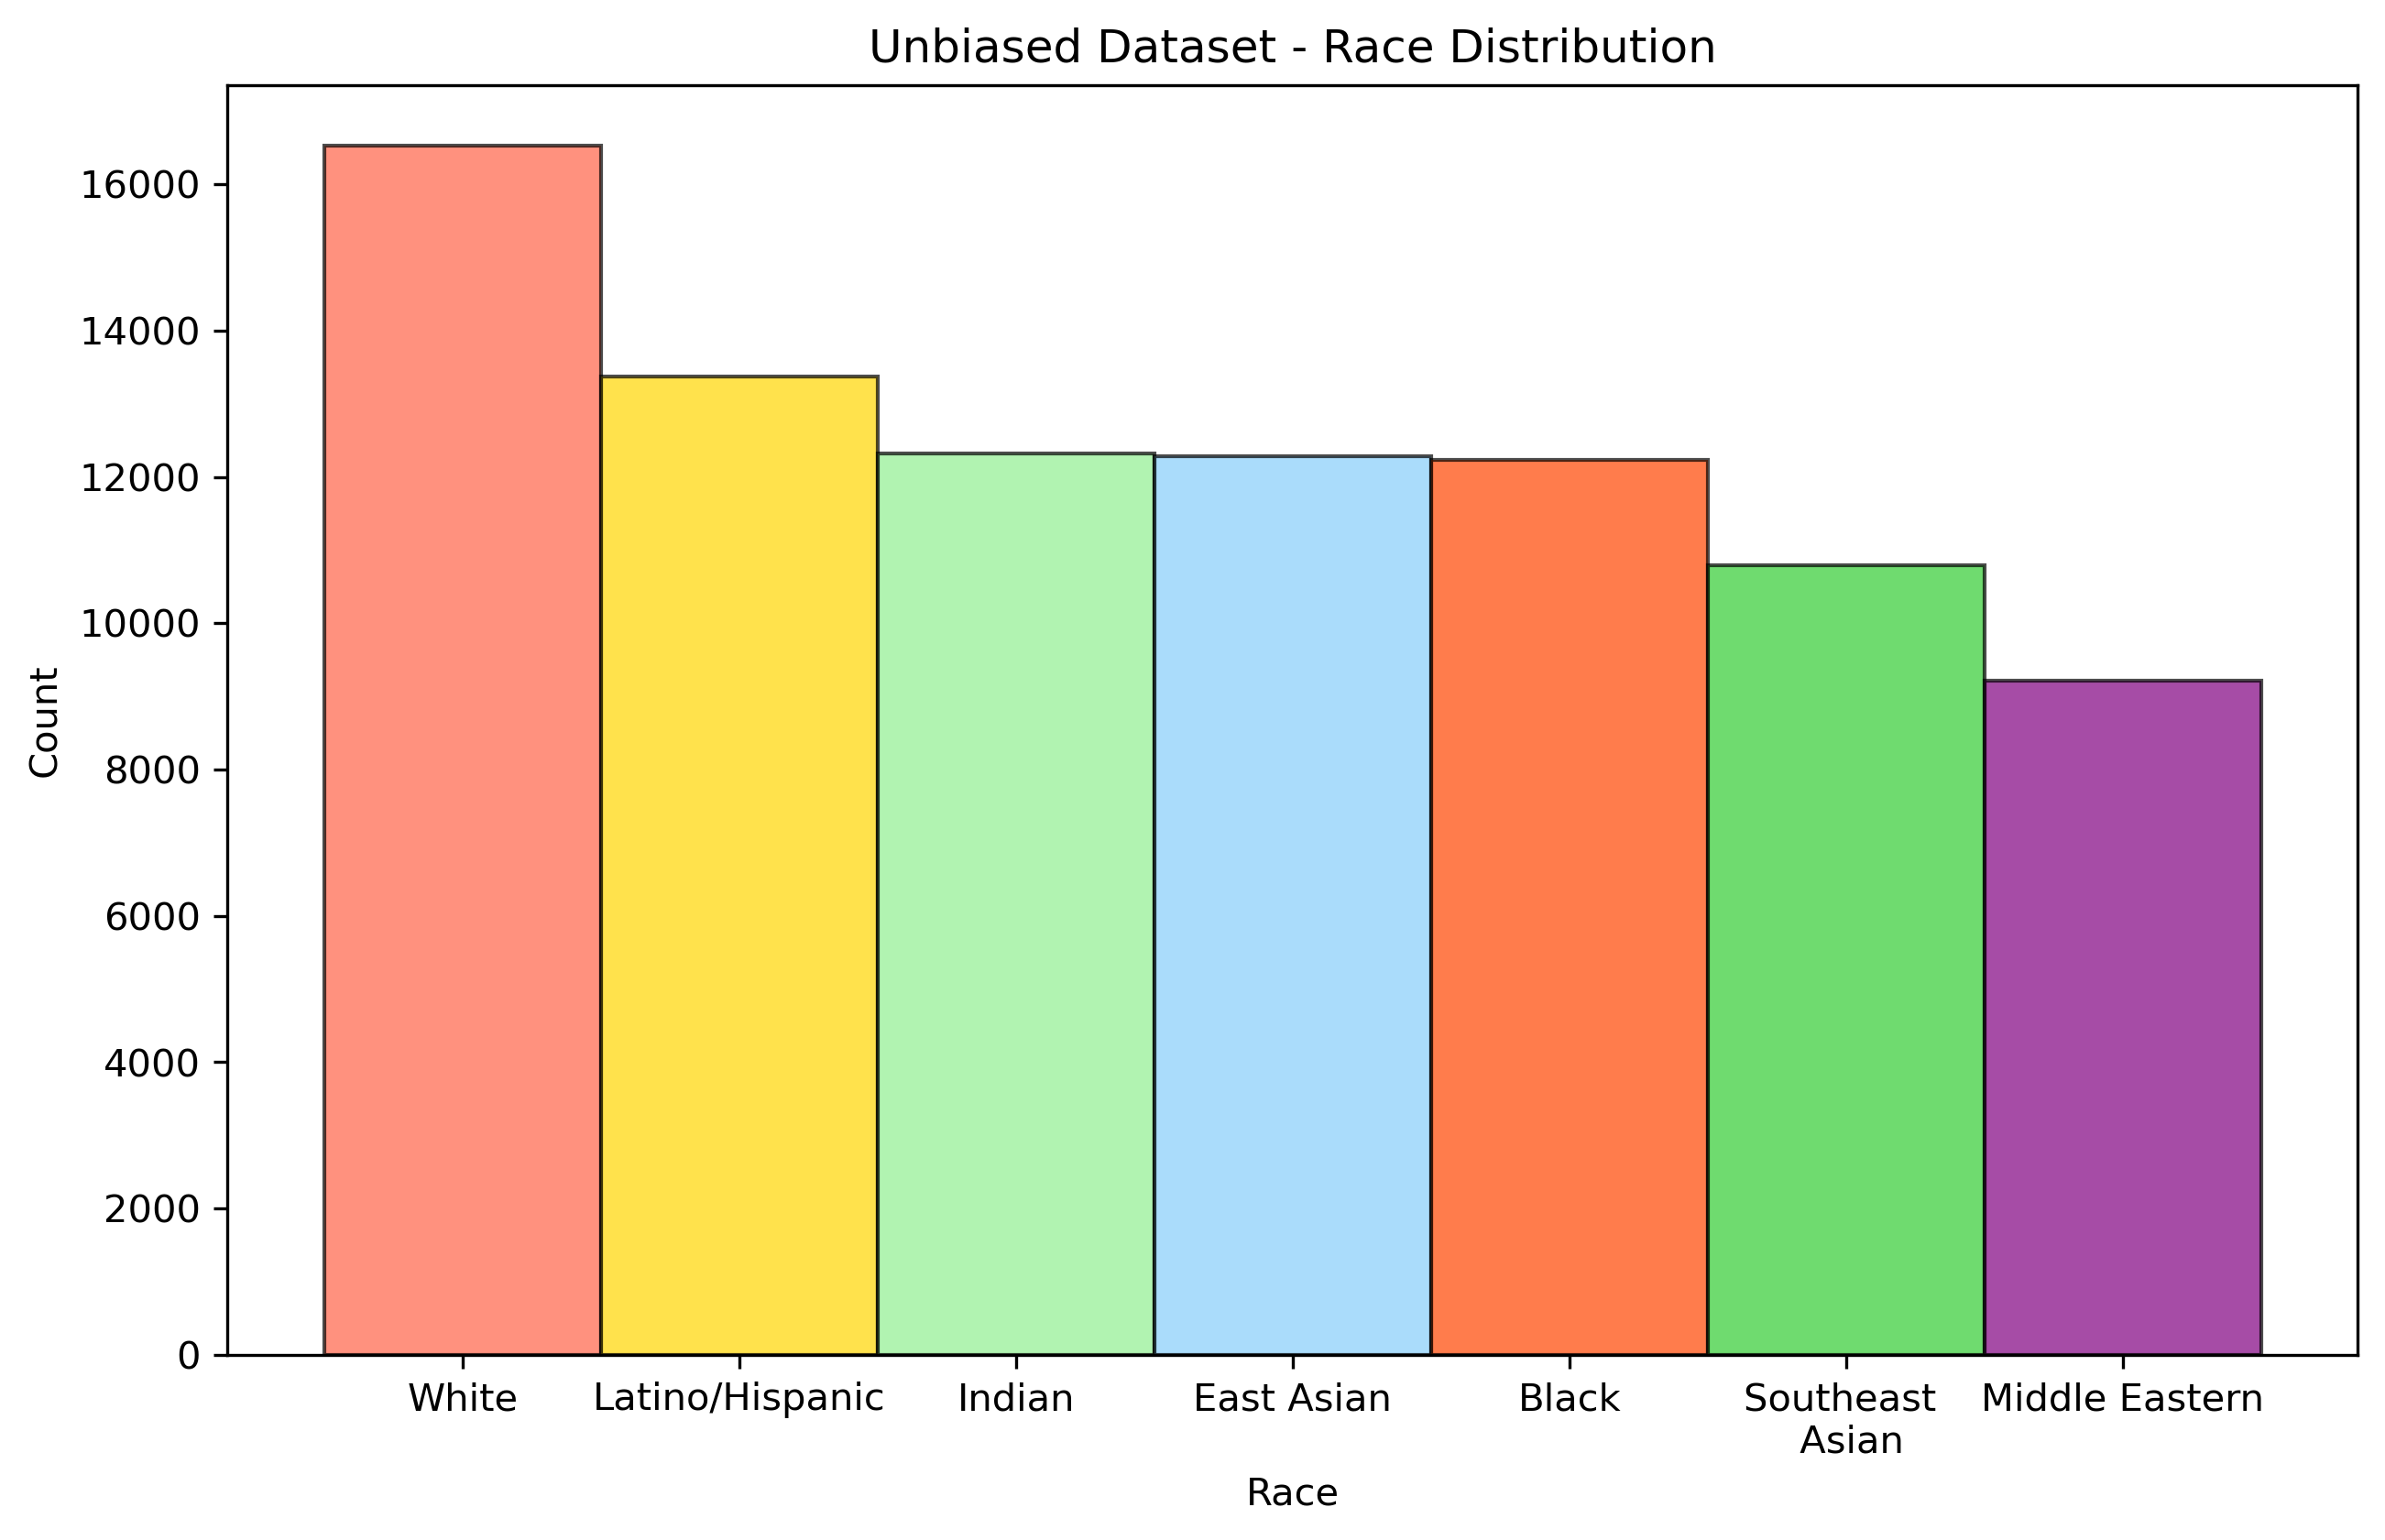

In [54]:
# Plot histograms for the unbiased dataset
plot_histogram(ds.anno, 'Unbiased Dataset - Age Distribution', 'age', 'Age Group', label_map={i: label for i, label in enumerate(age_labels)}, color_map=age_colors)
plot_histogram(ds.anno, 'Unbiased Dataset - Gender Distribution', 'gender', 'Gender', label_map={0: 'Male', 1: 'Female'}, color_map=gender_colors)
plot_histogram(ds.anno, 'Unbiased Dataset - Race Distribution', 'race', 'Race', label_map={i: label for i, label in enumerate(race_labels)}, color_map=race_colors)

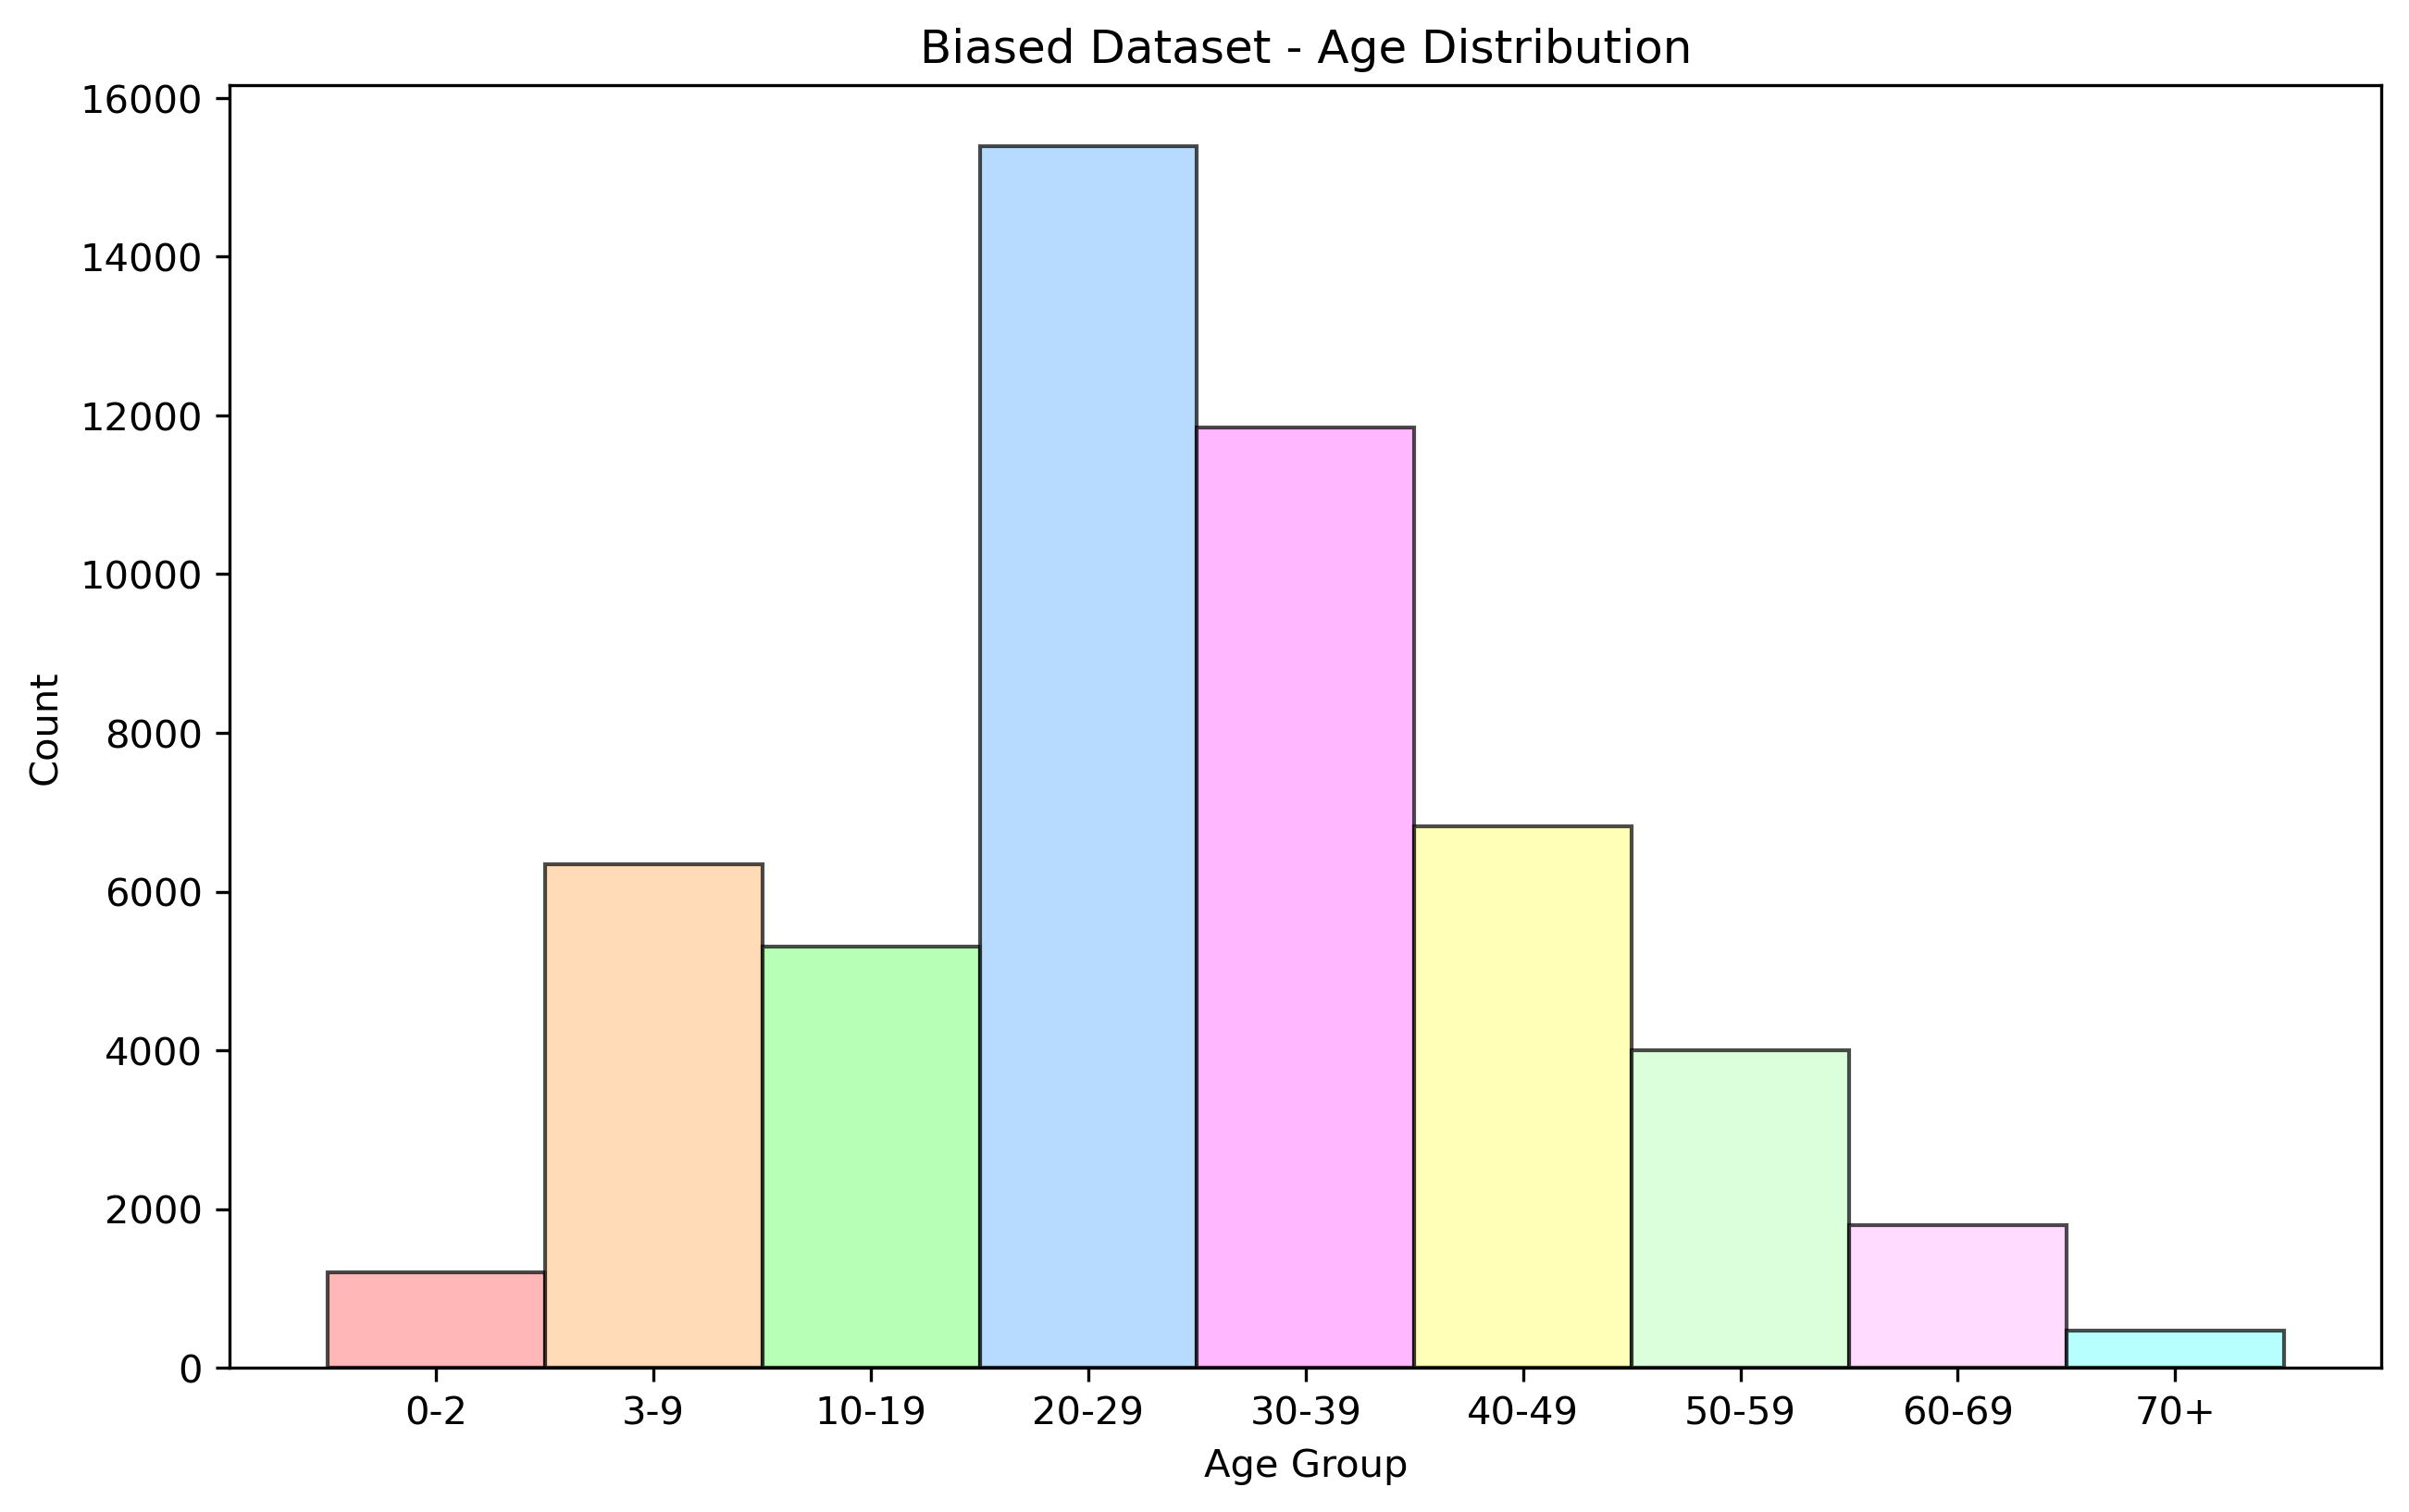

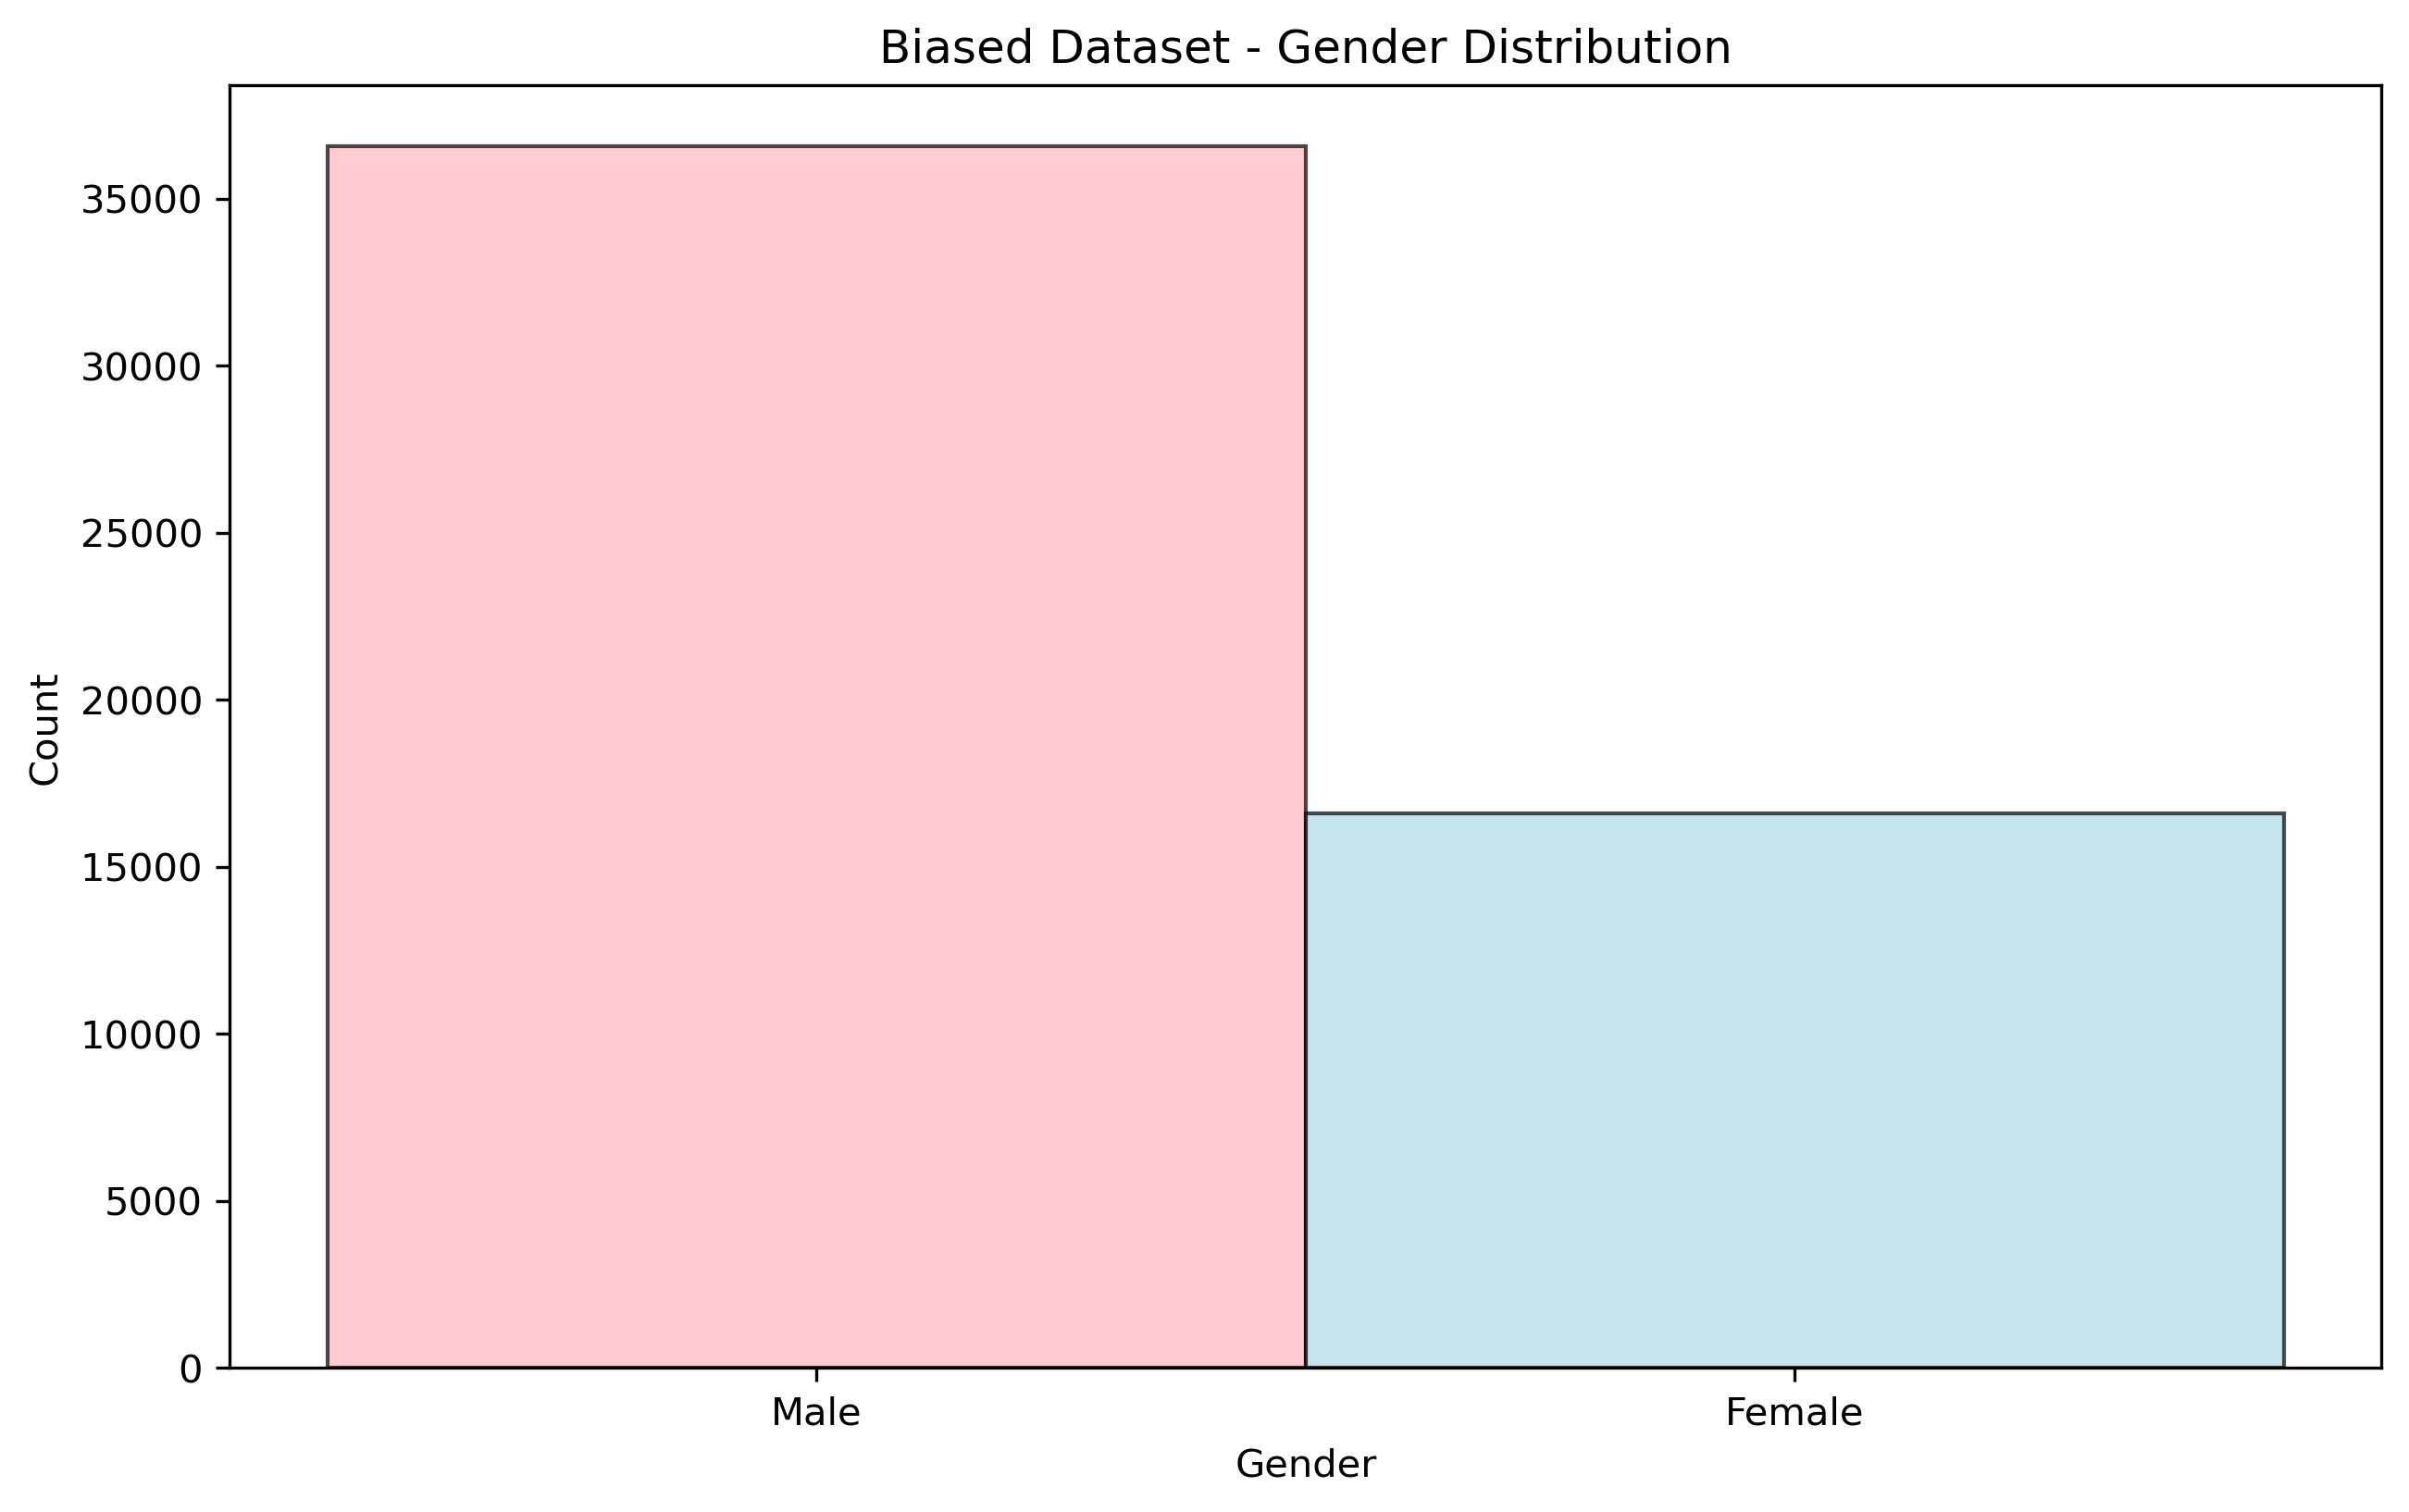

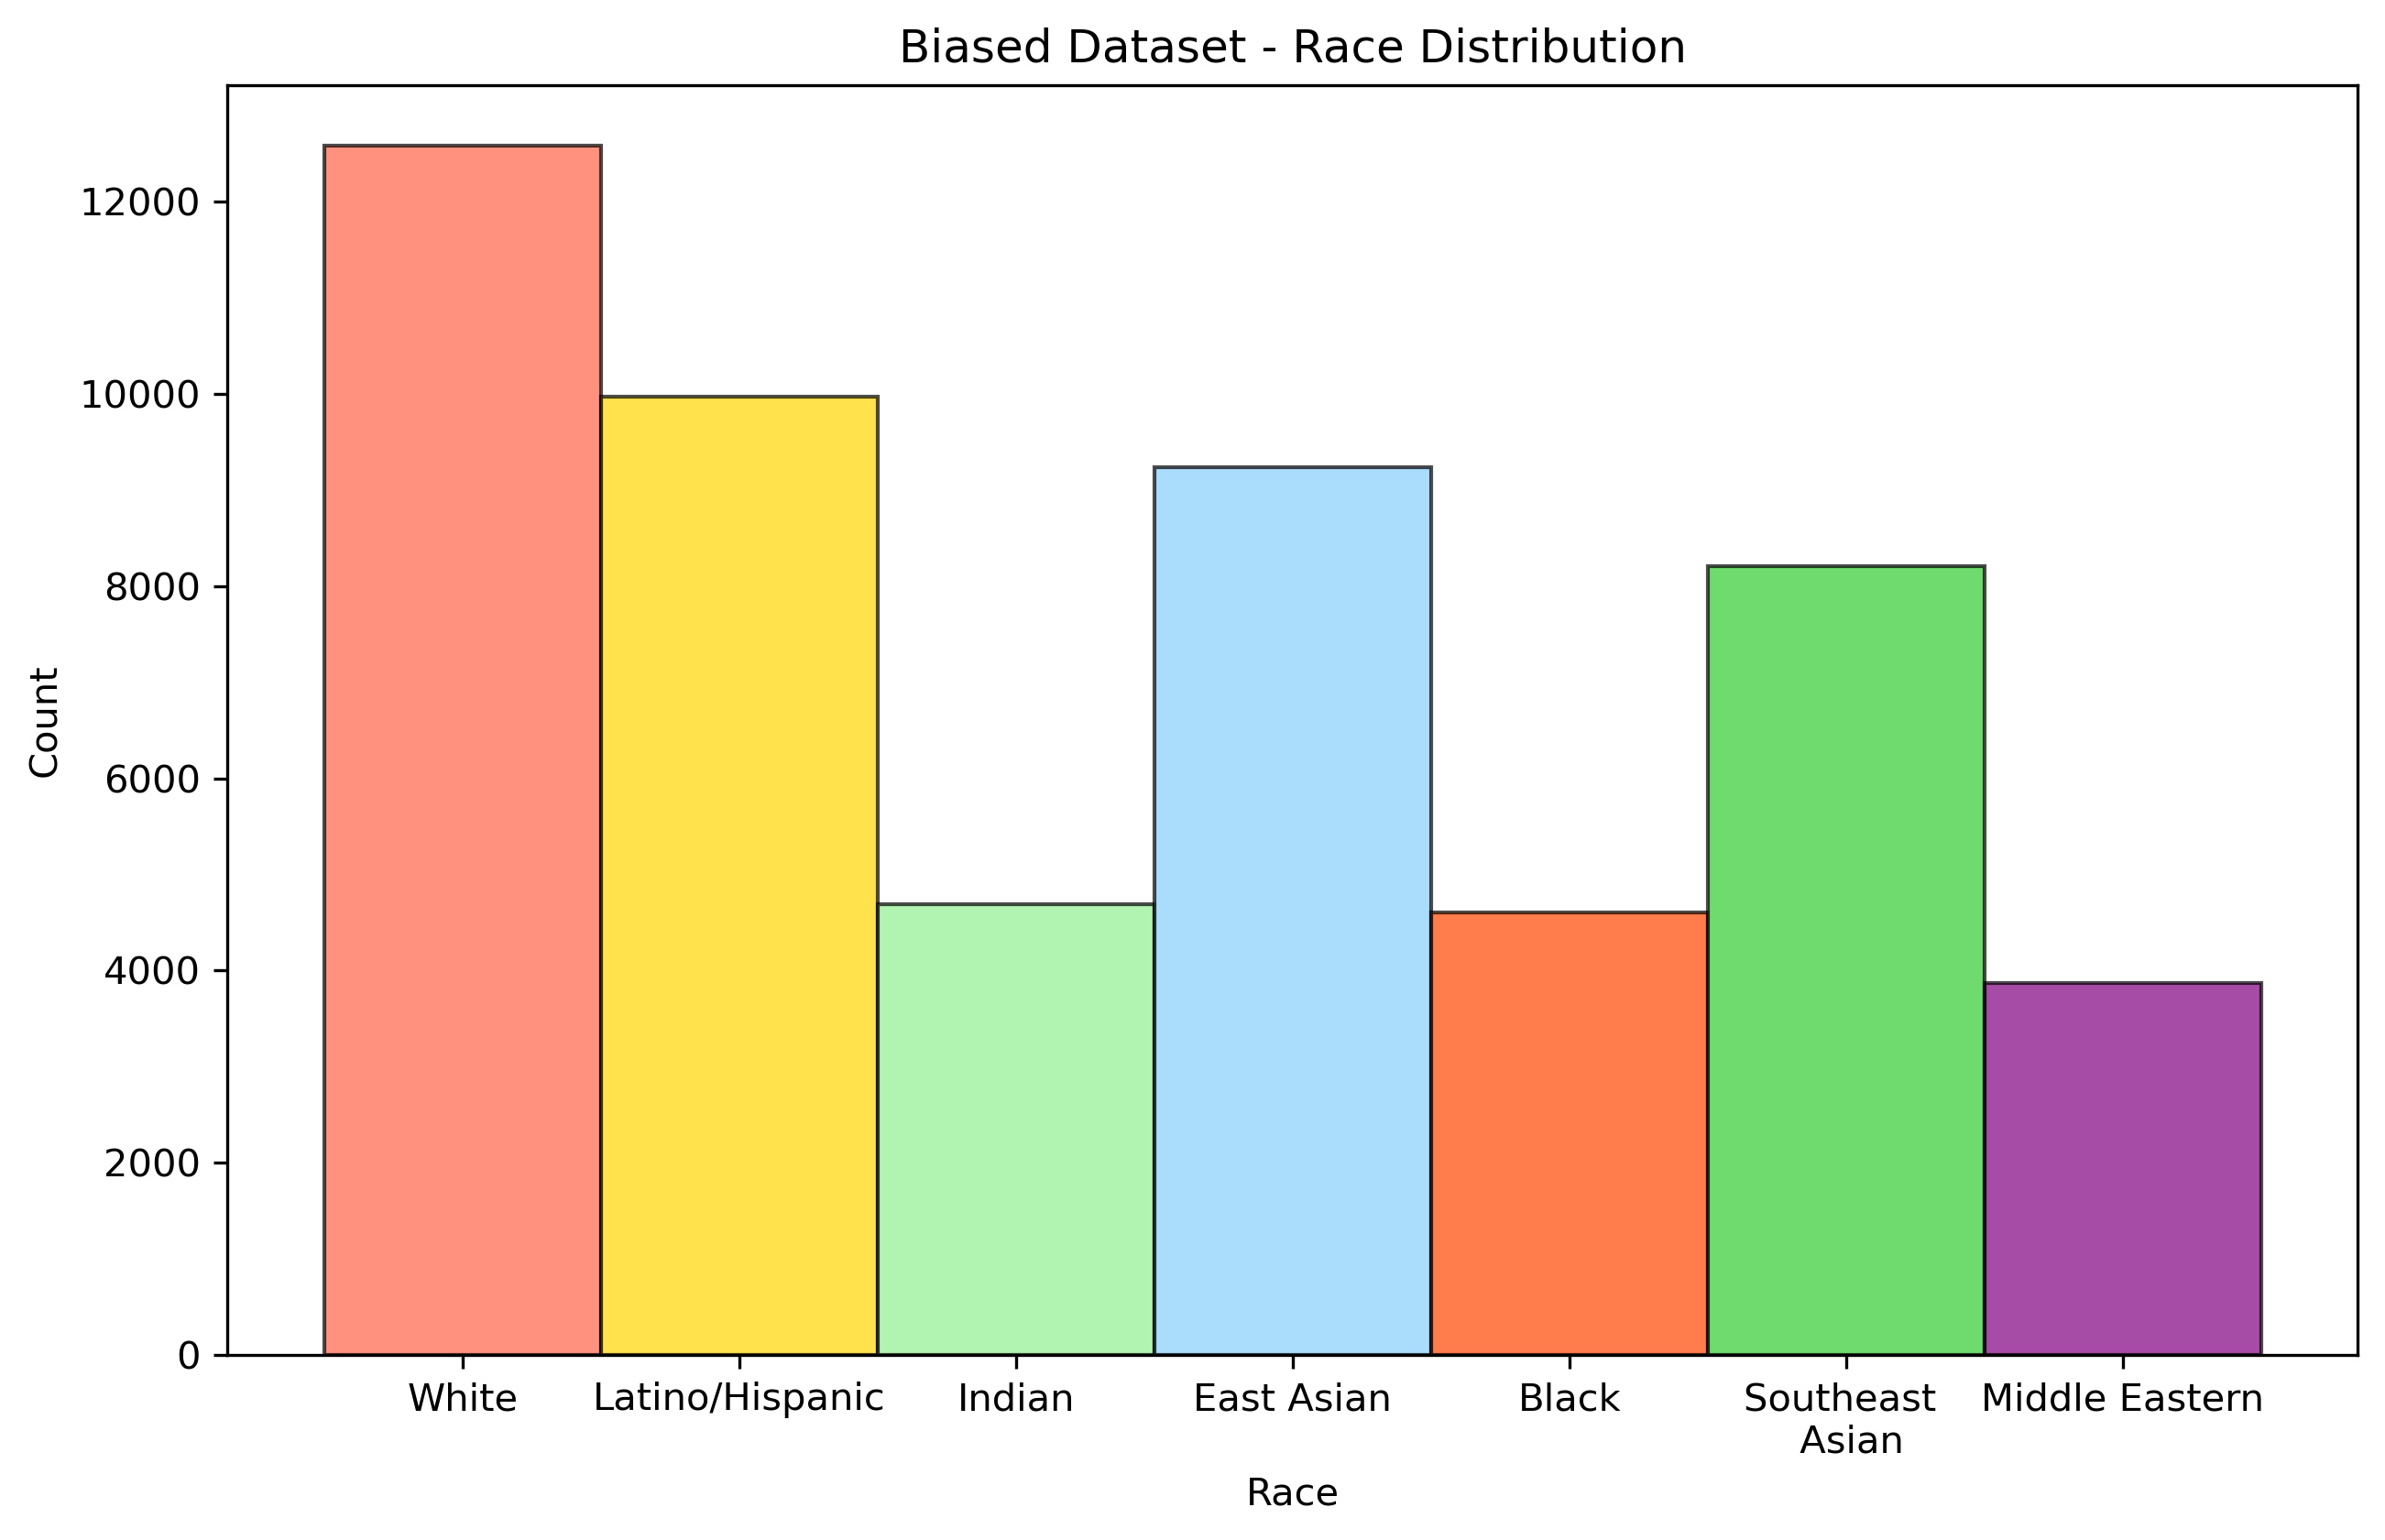

In [55]:
plot_histogram(ds2.anno, 'Biased Dataset - Age Distribution', 'age', 'Age Group', label_map={i: label for i, label in enumerate(age_labels)}, color_map=age_colors)
plot_histogram(ds2.anno, 'Biased Dataset - Gender Distribution', 'gender', 'Gender', label_map={0: 'Male', 1: 'Female'}, color_map=gender_colors)
plot_histogram(ds2.anno, 'Biased Dataset - Race Distribution', 'race', 'Race', label_map={i: label for i, label in enumerate(race_labels)}, color_map=race_colors)